In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model
import seaborn as sns
from matplotlib import rcParams
import matplotlib as mpl
from matplotlib.lines import Line2D
import glob
import re

In [3]:
# URLs and file paths
BASE_URL = 'https://raw.githubusercontent.com/igor-sadalski/Scaling-up-measurement-noise-scaling-laws/main/'
CALTECH_URL = 'https://raw.githubusercontent.com/ggdna/scScaling/main/results/'

# Label renaming dictionary
RENAME_DICT = {
    'celltype.l3': 'Cell type MI',
    'protein_counts': 'Protein MI',
    'clone': 'Clonal MI',
    'author_day': 'Temporal MI',
    'ng_idx': 'Spatial MI',
    'RandomProjection': 'Rand. Proj.'
}

# Load Caltech101 data
gaussian_df = pd.read_csv(f'{CALTECH_URL}Caltech101_Gaussian.csv')
gaussian_df['Scale'] = gaussian_df['Scale']**2
res_df = pd.read_csv(f'{CALTECH_URL}Caltech101_resolution.csv')

# Load single-cell data
df = pd.read_csv(f'{BASE_URL}collect_mi_results.csv').replace(RENAME_DICT)
sc_param_df = pd.read_csv(f'{BASE_URL}analysis/final_results/cell_scaling_N0_2328676.073_s_1.100_I_inf_3.141.csv').replace(RENAME_DICT)
sc_param_df_noise = pd.read_csv('analysis/final_results/scaling_plots_u_bar_138.109_I_max_1.419.csv').replace(RENAME_DICT)

# Load sequence data
seq_df = pd.read_csv('seq/multisize_gisaid_results.csv')

# Load TissueMNIST data
csv_files = glob.glob('images/tissuemnist_models/result_*.csv')
dfs_tissue = []
for file in csv_files:
    match = re.search(r'result_(.+)\.csv', file)
    if match.group(1) == 'clean':
        downsampling_type, downsampling_level = 'clean', 0.0
    elif 'pix' in match.group(1):
        downsampling_type = 'pixel'
        downsampling_level = float(match.group(1).split('_')[1][:-1])
    elif 'gauss' in match.group(1):
        downsampling_type = 'gaussian'
        downsampling_level = float(match.group(1).split('_')[1][:-1])
    else:
        downsampling_type, downsampling_level = 'unknown', 0.0
    
    df_temp = pd.read_csv(file)
    df_temp['downsampling_level'] = downsampling_level
    df_temp['downsampling_type'] = downsampling_type
    dfs_tissue.append(df_temp)

combined_df = pd.concat(dfs_tissue, ignore_index=True)

In [4]:
def cell_number_scaling(x, N0, s, I_inf):
    """Cell number scaling: I(x) = max(0, I_inf - (x/N0)^(-s))"""
    with np.errstate(divide="ignore", invalid="ignore", over="ignore"):
        ratio = x / N0
        scaling_term = np.where(ratio > 0, np.exp(-s * np.log(ratio)), 0.0)
        return np.where(x > 0, np.maximum(0, I_inf - scaling_term), np.nan)

def info_scaling(u, u_bar, I_max):
    """Information scaling: I(u) = I_max - 0.5*log2((1+u/u_bar)/(u/u_bar+2^(-2*I_max)))"""
    epsilon = 1e-12
    u, u_bar, I_max = np.asarray(u), np.asarray(u_bar), np.asarray(I_max)
    u_bar_safe = np.where(u_bar == 0, epsilon, u_bar)
    u_over_u_bar = u / u_bar_safe
    numerator = 1 + u_over_u_bar
    denominator = np.where(u_over_u_bar + 2**(-2*I_max) == 0, epsilon, u_over_u_bar + 2**(-2*I_max))
    ratio = np.where(numerator/denominator <= 0, epsilon, numerator/denominator)
    return I_max - 0.5 * np.log2(ratio)

def info_scaling_model(x, A, B):
    """Parameterized info scaling: 0.5*log2((x*B+1)/(1+A*x))"""
    return 0.5 * np.log2((x*B + 1)/(1 + A*x))

def transform_to_z(x, xbar, imax):
    """Transform to collapsed coordinate z"""
    A = 2**(-2*imax)
    return ((x/xbar) + A) / (1 - A)

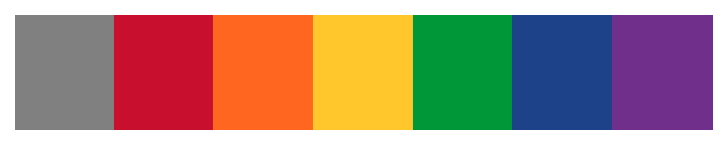

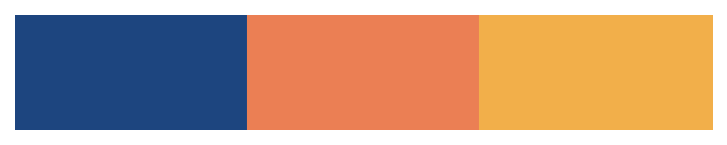

In [5]:
# style config 

sns.set_style('whitegrid')
rcParams.update({
    'figure.dpi': 150,
    'grid.linewidth': 0.5,
    'grid.linestyle': 'dashed',
    'legend.fancybox': False,
    'mathtext.fontset': 'stix'
})
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["svg.fonttype"] = 'none'

# Color palettes
c6 = ['#c4bae2', '#40ada6', '#3c4ebf', '#e3a600', '#d6543a', '#edb1a3']
pretty_palette = [c6[i] for i in [1,2,3,4]]
hue_order = ['Rand. Proj.', 'PCA', 'SCVI', 'Geneformer']

pretty_palette_metrics = "grey, #C8102EFF, #FF6720FF, #FFC72CFF, #009739FF, #1D4289FF, #702F8AFF".split(", ")
hue_order_metrics = ['Protein MI', 'Clonal MI', 'Temporal MI', 'Spatial MI', 'Caltech101-binary']

seq_colors = "#1D457FFF, #61599DFF, #C36377FF, #EB7F54FF, #F2AF4AFF".split(", ")
seq_colors = seq_colors[:1]  + seq_colors[3:4] + seq_colors[4:]

seq_color_collapse = pretty_palette_metrics[6]
tissue_color = pretty_palette_metrics[5]
# seq_color_collapse = sns.color_palette("Purples_r", n_colors=5)[0]
# seq_colors = sns.color_palette("Purples_r", n_colors=5)[:2]

palette_tissue = "#CBC106FF, #27993CFF, #1C6838FF, #8EBCB5FF, #389CA7FF, #4D83ABFF, #CB7B26FF, #BF565DFF, #9E163CFF".split(", ")

# show colors
def show_colors(colors):
    """Display a list of colors as horizontal bars."""
    fig, ax = plt.subplots(figsize=(6, 1))
    for i, color in enumerate(colors):
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))
    ax.set_xlim(0, len(colors))
    ax.set_ylim(0, 1)
    ax.axis('off')
show_colors(pretty_palette_metrics)
show_colors(seq_colors)

In [6]:
def plot_points(ax, x, y, color, label, marker='o', ms=2.5):
    """Plot scatter points"""
    ax.plot(x, y, color=color, marker=marker, alpha=0.7, ms=ms, label=label, lw=0)

def fit_info_model(x_data, y_data):
    """Fit info_scaling_model and return parameters if successful"""
    model = Model(info_scaling_model)
    params = model.make_params(A=1e-2, B=1e-2)
    params['A'].min = params['B'].min = 0
    
    try:
        result = model.fit(y_data, params, x=x_data)
        a, b = result.params['A'], result.params['B']
        if a.stderr and b.stderr and a.stderr < a.value and b.stderr < b.value:
            return 1/a.value, 0.5*np.log2(b.value/a.value), result
    except:
        pass
    return None, None, None

def plot_precomputed_scaling(ax, df, param_df, color_map, marker_map):
    """Plot precomputed scaling collapse data"""
    hue_order_methods = ['PCA', 'SCVI', 'Geneformer']
    n_curves = 0
    
    for sig in hue_order_metrics:
        if sig == 'Caltech101-binary':
            continue
        for q in df['quality'].unique():
            if q < 1:
                continue
            for alg in hue_order_methods:
                data = df[(df['signal']==sig) & (df['quality']==q) & (df['algorithm']==alg)]
                if len(data) < 10:
                    continue
                
                avg_data = data.groupby('size').mi_value.mean()
                p = param_df[(param_df['metric']==sig) & (param_df['method']==alg) & (param_df['quality']==q)]
                if p.empty:
                    continue
                
                s, N0, I_inf = p['s'].values[0], p['N0'].values[0], p['I_inf'].values[0]
                N_hat = avg_data.index / N0
                plot_points(ax, N_hat, (I_inf - avg_data.values)**(-1/s), 
                           color_map[alg], None, marker_map[sig], ms=5)
                n_curves += 1
    
    print(f'Plotted {n_curves} scaling curves.')

def plot_precomputed_noise(ax, df, param_df, palette):
    """Plot precomputed noise collapse data"""
    hue_order_methods = ['PCA', 'SCVI', 'Geneformer', 'Rand. Proj.']
    n_curves = 0
    
    for idx, sig in enumerate(hue_order_metrics):
        if sig == 'Caltech101-binary':
            continue
        for size in df['size'].unique():
            for alg in hue_order_methods:
                data = df[(df['signal']==sig) & (df['size']==size) & (df['algorithm']==alg)]
                if len(data) < 10:
                    continue
                
                avg_data = data.groupby('umis_per_cell').mi_value.mean()
                p = param_df[(param_df['metric']==sig) & (param_df['method']==alg) & (param_df['size']==size)]
                if p.empty:
                    continue
                
                xbar, imax = p['fitted_u_bar'].values[0], p['fitted_I_max'].values[0]
                xbar_err, imax_err = p['u_bar_error'].values[0], p['I_max_error'].values[0]
                
                if True:#xbar_err < xbar and imax_err < imax:
                    z = transform_to_z(avg_data.index, xbar, imax)
                    plot_points(ax, z, avg_data.values - imax, palette[idx], sig)
                    n_curves += 1
    
    print(f'Plotted {n_curves} noise curves.')

def fit_and_plot_caltech(ax, df, x_col, color):
    """Fit and plot Caltech101 data"""
    for class_label in df['Class label'].unique()[:-1]:
        data = df[df['Class label'] == class_label]
        x_data, y_data = 1/data[x_col], data['MI']
        
        x_bar, i_max, _ = fit_info_model(x_data, y_data)
        if x_bar and i_max:
            z = transform_to_z(x_data, x_bar, i_max)
            plot_points(ax, z, y_data - i_max, color, 'Caltech101-binary')

def fit_and_plot_sequences(ax, seq_df, color):
    """Fit and plot sequence data for multiple model sizes"""
    model_sizes = sorted(seq_df['model_size'].unique())
    
    for idx, model_size in enumerate(model_sizes):
        data = seq_df[seq_df['model_size'] == model_size]
        x_data = data['true/error']
        y_data = data['mutual_information']
        
        x_bar, i_max, _ = fit_info_model(x_data, y_data)
        if x_bar and i_max:
            z = transform_to_z(x_data, x_bar, i_max)
            plot_points(ax, z, y_data - i_max, color, f'Spike seqs.')
            print(f'Sequences {model_size}: x_bar={x_bar:.2f}, i_max={i_max:.2f}')

def fit_and_plot_tissue(ax, combined_df, downsampling_type, tissue_color):
    """Fit and plot TissueMNIST data"""
    data_subset = combined_df[combined_df['downsampling_type'] == downsampling_type].copy()
    x_transform = (lambda x: x**2) if downsampling_type == 'pixel' else (lambda x: x)
    data_subset['inv_factor'] = 1 / data_subset['downsampling_level']
    
    ova_columns = ['mi_score'] + [col for col in data_subset.columns if 'ova_mi_continuous' in col]
    
    for col in ova_columns[::-1]:
        mask = ~data_subset[col].isna() & ~data_subset['inv_factor'].isna()
        x_data = x_transform(data_subset[mask]['inv_factor'].values)
        y_data = data_subset[mask][col].values
        
        if len(x_data) < 3:
            continue
        
        x_bar, i_max, _ = fit_info_model(x_data, y_data)
        if x_bar and i_max:
            z = transform_to_z(x_data, x_bar, i_max)
            plot_points(ax, z, y_data - i_max, tissue_color, 'TissueMNIST')

/tmp/ipykernel_3937059/2201747182.py:43: RuntimeWarning: invalid value encountered in power
  plot_points(ax, N_hat, (I_inf - avg_data.values)**(-1/s),


Plotted 12 scaling curves.
Plotted 160 noise curves.
Sequences 150M: x_bar=13.09, i_max=2.83
Sequences 35M: x_bar=18.79, i_max=2.99
Sequences 8M: x_bar=36.76, i_max=3.02


/tmp/ipykernel_3937059/4057535633.py:279: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


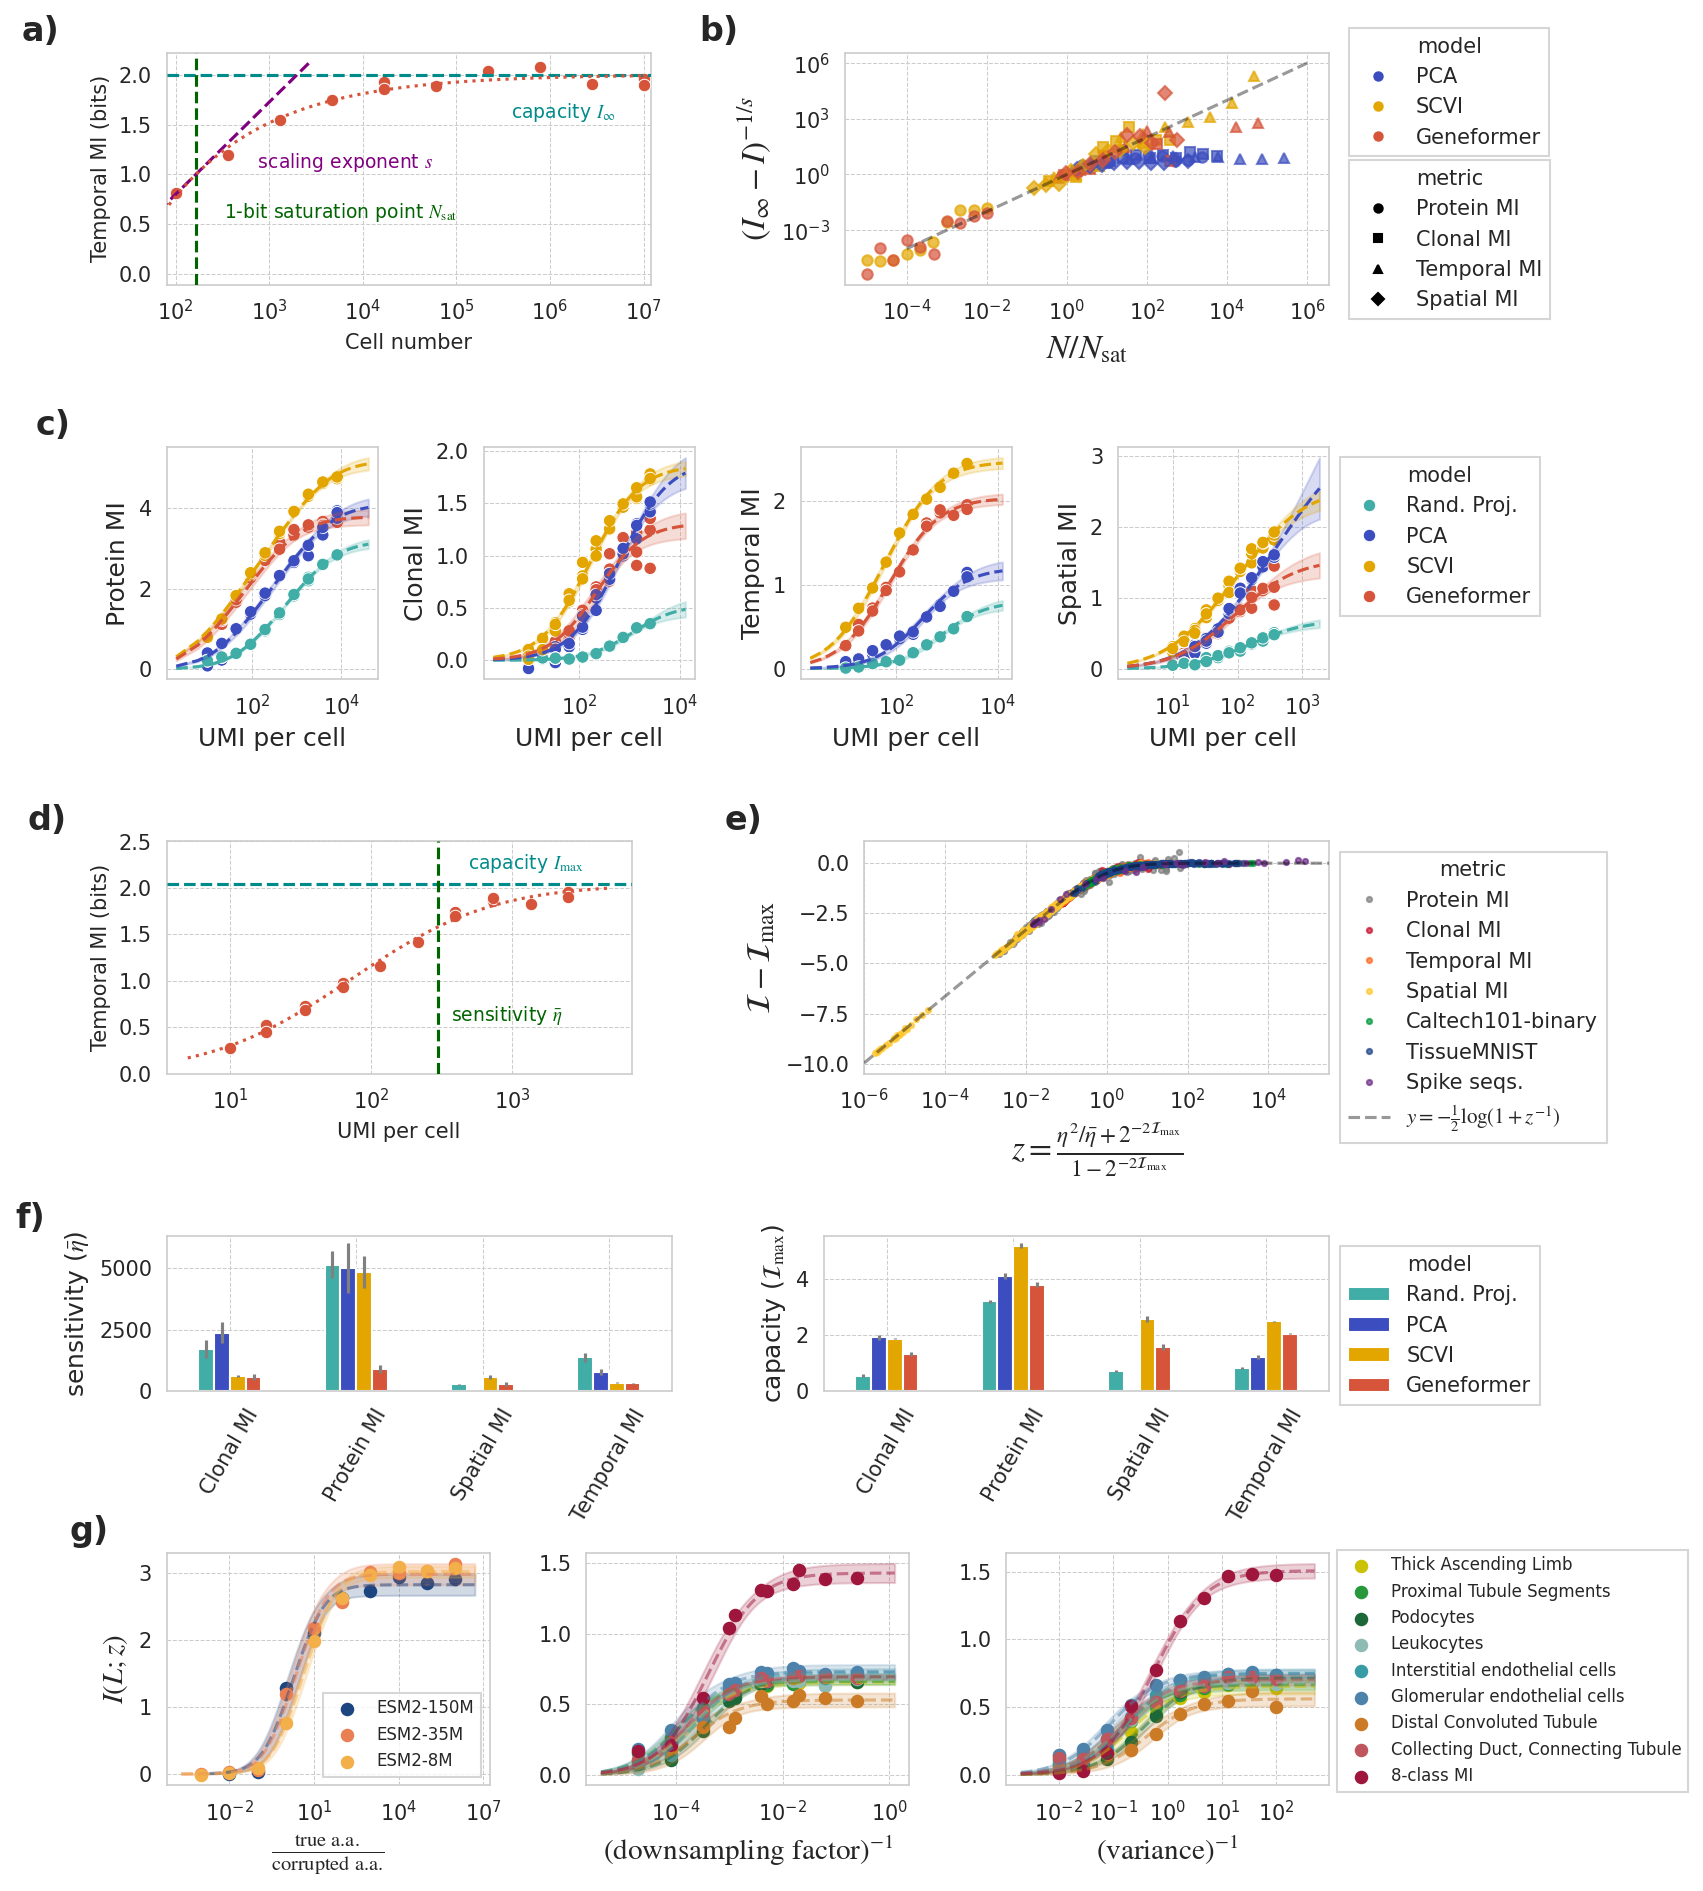

In [7]:
fig = plt.figure(figsize=(10, 15), dpi=150)
gs_main = fig.add_gridspec(5, 1, height_ratios=[3, 3, 3, 2, 3], hspace=0.75)

# ============================================================================
# ROW 1: Cell Number Scaling
# ============================================================================
gs_row1 = gs_main[0].subgridspec(1, 2, wspace=0.4)

# Panel a: Scaling example
ax_a = fig.add_subplot(gs_row1[0])
metric, method = 'Temporal MI', 'Geneformer'
subset = sc_param_df[(sc_param_df['quality']==1) & (sc_param_df['method']==method) & (sc_param_df['metric']==metric)]
s, N0, I_inf = subset['s'].values[0], subset['N0'].values[0], subset['I_inf'].values[0]

data = df[(df['quality']==1) & (df['algorithm']==method) & (df['signal']==metric)]
sns.scatterplot(data=data, x='size', y='mi_value', color=pretty_palette[3], ax=ax_a, legend=False, zorder=3)

xs = np.logspace(1, 7, 100)
ys = np.maximum(I_inf - (xs/N0)**(-s), 0)
ax_a.plot(xs, ys, linestyle=':', color=pretty_palette[3], zorder=20)

# Annotations
ax_a.axhline(I_inf, linestyle='dashed', color='darkcyan', zorder=10, lw=1.5)
ax_a.text(data['size'].max()/2, I_inf-0.5, f'capacity $I_\\infty$', ha='right', va='bottom', color='darkcyan', fontsize=9)

ax_a.axvline(N0, linestyle='dashed', color='darkgreen', zorder=10, lw=1.5)
ax_a.text(N0*2, 0.5, r'1-bit saturation point $N_{\text{sat}}$', ha='left', va='bottom', color='darkgreen', fontsize=9)

y_tangent = I_inf - 1
x_tan_1, x_tan_2 = N0/8, N0*16
y_tan_1 = s*np.log(x_tan_1) - s*np.log(N0) + y_tangent
y_tan_2 = s*np.log(x_tan_2) - s*np.log(N0) + y_tangent
ax_a.plot([x_tan_1, x_tan_2], [y_tan_1, y_tan_2], linestyle='dashed', color='purple', zorder=10, lw=1.5)
ax_a.text(x_tan_2/4, y_tan_2-1, f' scaling exponent $s$', ha='left', va='center', color='purple', fontsize=9)

ax_a.set_xscale('log')
ax_a.set_xlabel('Cell number')
ax_a.set_ylabel('Temporal MI (bits)')
ax_a.set_xlim(data['size'].min()*0.8, data['size'].max()*1.2)

# Panel b: Scaling collapse
ax_b = fig.add_subplot(gs_row1[1])
hue_order_methods = ['PCA', 'SCVI', 'Geneformer']
markers = ['o', 's', '^', 'D', 'v']
color_map = {method: pretty_palette[i+1] for i, method in enumerate(hue_order_methods)}
marker_map = {metric: markers[i] for i, metric in enumerate(hue_order_metrics) if metric != 'Caltech101-binary'}

plot_precomputed_scaling(ax_b, df, sc_param_df, color_map, marker_map)

xs = np.logspace(-4, 6, 100)
ax_b.plot(xs, xs, color='black', linestyle='--', alpha=0.4, lw=1.5, label=r'$y = x$', zorder=10)
ax_b.set_xscale('log')
ax_b.set_yscale('log')
ax_b.set_xlabel(r'$N/N_{\text{sat}}$', fontsize=16)
ax_b.set_ylabel(r'$(I_{\infty} - I)^{-1/s}$', fontsize=16)

method_handles = [Line2D([0], [0], color=color_map[m], marker='o', linestyle='None', label=m, ms=4) for m in hue_order_methods]
leg1 = ax_b.legend(handles=method_handles, loc='upper left', bbox_to_anchor=(1.02, 1.15), title='model')
metric_handles = [Line2D([0], [0], color='black', marker=marker_map[m], linestyle='None', label=m, ms=4) 
                  for m in hue_order_metrics if m != 'Caltech101-binary']
leg2 = ax_b.legend(handles=metric_handles, loc='upper left', bbox_to_anchor=(1.02, 0.58), title='metric')
ax_b.add_artist(leg1)

# ============================================================================
# ROW 2: Noise Examples
# ============================================================================
gs_row2 = gs_main[1].subgridspec(1, 4, wspace=0.5)
axs_c = [fig.add_subplot(gs_row2[i]) for i in range(4)]

for ax, sig in zip(axs_c, hue_order_metrics):
    if sig == 'Caltech101-binary':
        continue
    sub = df[df['signal'] == sig]
    max_sub = sub[sub['size'] == sub['size'].max()]
    
    sns.scatterplot(data=max_sub, x='umis_per_cell', y='mi_value', hue='algorithm', 
                   palette=pretty_palette, hue_order=hue_order, ax=ax, legend=ax==axs_c[-1])
    
    for i, alg in enumerate(hue_order):
        dat = max_sub[max_sub['algorithm'] == alg]
        if len(dat) < 9:
            continue
        
        _, _, result = fit_info_model(dat['umis_per_cell'], dat['mi_value'])
        if result:
            x_fit = np.linspace(dat['umis_per_cell'].min()/5, dat['umis_per_cell'].max()*5, 10000)
            y_fit = result.eval(x=x_fit)
            y_err = result.eval_uncertainty(x=x_fit, sigma=2)
            ax.fill_between(x_fit, y_fit+y_err, y_fit-y_err, color=pretty_palette[i], alpha=0.2)
            ax.plot(x_fit, y_fit, color=pretty_palette[i], linestyle='--')
    
    ax.set_xscale('log')
    ax.set_ylabel(sig, fontsize=12)
    ax.set_xlabel('UMI per cell', fontsize=12)

if axs_c[-1].get_legend():
    sns.move_legend(axs_c[-1], 'upper left', bbox_to_anchor=(1, 1), title='model')

# ============================================================================
# ROW 3: Noise Collapse
# ============================================================================
gs_row3 = gs_main[2].subgridspec(1, 2, width_ratios=[4, 4], wspace=0.5)

# Panel d: Noise annotation
ax_d = fig.add_subplot(gs_row3[0])
metric, method = 'Temporal MI', 'Geneformer'
max_cell_number = df[df['signal'] == metric]['size'].max()
subset = sc_param_df_noise[(sc_param_df_noise['size']==max_cell_number) & 
                           (sc_param_df_noise['method']==method) & (sc_param_df_noise['metric']==metric)]
u_bar, I_max = subset['fitted_u_bar'].values[0], subset['fitted_I_max'].values[0]

data = df[(df['size']==max_cell_number) & (df['algorithm']==method) & (df['signal']==metric)]
sns.scatterplot(data=data, x='umis_per_cell', y='mi_value', color=pretty_palette[3], ax=ax_d, legend=False, zorder=3)

xs = np.logspace(np.log10(data['umis_per_cell'].min()/2), np.log10(data['umis_per_cell'].max()*2), 100)
ys = np.maximum(I_max - 0.5*np.log2((1 + xs/u_bar)/(xs/u_bar + 2**(-2*I_max))), 0)
ax_d.plot(xs, ys, linestyle=':', color=pretty_palette[3], zorder=20)

ax_d.axhline(I_max, linestyle='dashed', color='darkcyan', zorder=10, lw=1.5)
ax_d.text(data['umis_per_cell'].max()/2, I_max+0.1, f'capacity $I_\\max$', ha='center', va='bottom', color='darkcyan', fontsize=9)

ax_d.axvline(u_bar, linestyle='dashed', color='darkgreen', zorder=10, lw=1.5)
ax_d.text(u_bar*1.25, 0.5, f'sensitivity $\\bar{{\\eta}}$', ha='left', va='bottom', color='darkgreen', fontsize=9)

ax_d.set_xscale('log')
ax_d.set_ylim(0, 2.5)
ax_d.set_xlabel('UMI per cell')
ax_d.set_ylabel('Temporal MI (bits)')

# Panel e: Noise collapse
ax_e = fig.add_subplot(gs_row3[1])

plot_precomputed_noise(ax_e, df, sc_param_df_noise, pretty_palette_metrics)
fit_and_plot_caltech(ax_e, gaussian_df, 'Scale', pretty_palette_metrics[4])
fit_and_plot_caltech(ax_e, res_df, 'Factor', pretty_palette_metrics[4])
fit_and_plot_tissue(ax_e, combined_df, 'pixel', tissue_color)
fit_and_plot_tissue(ax_e, combined_df, 'gaussian', tissue_color)
fit_and_plot_sequences(ax_e, seq_df, seq_color_collapse)

xs = np.logspace(-6, 5.5, 100)
ax_e.plot(xs, -np.log2((1+xs)/xs)/2, color='black', linestyle='--', alpha=0.4, lw=1.5, 
         label=r'$y = -\frac{1}{2}\log(1 + z^{-1})$', zorder=10)
ax_e.set_xscale('log')
ax_e.set_xlim(xs.min(), xs.max())
ax_e.set_ylabel(r'$\mathcal{I} - \mathcal{I}_{\max}$', fontsize=16)
ax_e.set_xlabel(r'$z = \frac{\eta^2/\bar{\eta} + 2^{-2\mathcal{I}_{\max}}}{1 - 2^{-2\mathcal{I}_{\max}}}$', fontsize=16)

handles, labels = ax_e.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax_e.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1.0, 1.), title='metric')

# ============================================================================
# ROW 4: Parameter Bars
# ============================================================================
gs_row4 = gs_main[3].subgridspec(1, 2, wspace=0.3)
axs_f = [fig.add_subplot(gs_row4[i]) for i in range(2)]

noise_df = pd.read_csv('analysis/final_results/scaling_plots_u_bar_138.109_I_max_1.419.csv')
noise_df = noise_df[noise_df['I_max_error'] < 0.5]
noise_df = noise_df[noise_df['metric'] != 'celltype.l3']
noise_df = noise_df[noise_df['size'].isin(noise_df.groupby('dataset')['size'].max().values)]
noise_df.replace(RENAME_DICT, inplace=True)

means = noise_df.pivot(index='metric', columns='method', values='fitted_u_bar')
errors = noise_df.pivot(index='metric', columns='method', values='u_bar_error')
means[hue_order].plot(kind='bar', yerr=errors, ax=axs_f[0], color=pretty_palette, 
                      capsize=0, ecolor='grey', rot=0, legend=False)
axs_f[0].set_xlabel('')
axs_f[0].set_ylabel(r'sensitivity ($\bar{\eta}$)', fontsize=12)
axs_f[0].tick_params(axis='x', rotation=60)

means = noise_df.pivot(index='metric', columns='method', values='fitted_I_max')
errors = noise_df.pivot(index='metric', columns='method', values='I_max_error')
means[hue_order].plot(kind='bar', yerr=errors, ax=axs_f[1], color=pretty_palette,
                      capsize=0, ecolor='grey', rot=0)
axs_f[1].set_xlabel('')
axs_f[1].set_ylabel(r'capacity ($\mathcal{I}_{\max}$)', fontsize=12)
axs_f[1].legend(title='model', bbox_to_anchor=(1.0, 1), loc='upper left')
axs_f[1].tick_params(axis='x', rotation=60)

# ============================================================================
# ROW 5: TissueMNIST and Sequences
# ============================================================================
gs_row5 = gs_main[4].subgridspec(1, 3, wspace=0.3)
axs_g = [fig.add_subplot(gs_row5[i]) for i in range(3)]

label_map = {
    'ova_mi_continuous_Class_0': 'Collecting Duct, Connecting Tubule',
    'ova_mi_continuous_Class_1': 'Distal Convoluted Tubule',
    'ova_mi_continuous_Class_2': 'Glomerular endothelial cells',
    'ova_mi_continuous_Class_3': 'Interstitial endothelial cells',
    'ova_mi_continuous_Class_4': 'Leukocytes',
    'ova_mi_continuous_Class_5': 'Podocytes',
    'ova_mi_continuous_Class_6': 'Proximal Tubule Segments',
    'ova_mi_continuous_Class_7': 'Thick Ascending Limb',
    'mi_score': '8-class MI',
}



# Panel g1: Sequences
model_sizes = sorted(seq_df['model_size'].unique())

for idx, model_size in enumerate(model_sizes):
    data = seq_df[seq_df['model_size'] == model_size]
    x_data = data['true/error']
    y_data = data['mutual_information']
    
    color = seq_colors[idx % len(seq_colors)]
    
    _, _, result = fit_info_model(x_data, y_data)
    if result:
        x_fit = np.logspace(np.log10(x_data.min()/5), np.log10(5*x_data.max()), 100000)
        y_fit = result.eval(x=x_fit)
        y_err = result.eval_uncertainty(x=x_fit, sigma=2)
        axs_g[0].plot(x_fit, y_fit, linestyle='--', color=color, alpha=0.5)
        axs_g[0].fill_between(x_fit, y_fit+y_err, y_fit-y_err, color=color, alpha=0.2)
    
    axs_g[0].scatter(x_data, y_data, color=color, s=30, label=f'ESM2-{model_size}')

axs_g[0].set_xlabel(r'$\frac{\text{true a.a.}}{\text{corrupted a.a.}}$', fontsize=14)
axs_g[0].set_ylabel(r'$I(L; z)$', fontsize=14)
axs_g[0].set_xscale('log')
axs_g[0].legend(loc='lower right', fontsize=8)



# Panel g2: Pixel downsampling
pix = combined_df[combined_df['downsampling_type'] == 'pixel'].copy()
pix['inv_factor'] = 1 / pix['downsampling_level']
ova_columns = ['mi_score'] + [col for col in pix.columns if 'ova_mi_continuous' in col]

for i, col in enumerate(ova_columns[::-1]):
    mask = ~pix[col].isna() & ~pix['inv_factor'].isna()
    x_data, y_data = pix[mask]['inv_factor'].values**2, pix[mask][col].values
    
    _, _, result = fit_info_model(x_data, y_data)
    if result:
        x_fit = np.logspace(np.log10(x_data.min()/5), np.log10(5*x_data.max()), 100000)
        y_fit = result.eval(x=x_fit)
        y_err = result.eval_uncertainty(x=x_fit, sigma=2)
        axs_g[1].plot(x_fit, y_fit, linestyle='--', color=palette_tissue[i], alpha=0.5)
        axs_g[1].fill_between(x_fit, y_fit+y_err, y_fit-y_err, color=palette_tissue[i], alpha=0.2)
    
    axs_g[1].scatter(x_data, y_data, color=palette_tissue[i], label=label_map.get(col, col), s=30)

axs_g[1].set_xlabel(r'$(\text{downsampling factor})^{-1}$', fontsize=14)
axs_g[1].set_xscale('log')

# Panel g3: Gaussian noise
gauss = combined_df[combined_df['downsampling_type'] == 'gaussian'].copy()

for i, col in enumerate(ova_columns[::-1]):
    mask = ~gauss[col].isna()
    x_data, y_data = 1/gauss[mask]['downsampling_level'].values, gauss[mask][col].values
    
    _, _, result = fit_info_model(x_data, y_data)
    if result:
        x_fit = np.logspace(np.log10(x_data.min()/5), np.log10(5*x_data.max()), 100000)
        y_fit = result.eval(x=x_fit)
        y_err = result.eval_uncertainty(x=x_fit, sigma=2)
        axs_g[2].plot(x_fit, y_fit, linestyle='--', color=palette_tissue[i], alpha=0.5)
        axs_g[2].fill_between(x_fit, y_fit+y_err, y_fit-y_err, color=palette_tissue[i], alpha=0.2)
    
    axs_g[2].scatter(x_data, y_data, color=palette_tissue[i], label=label_map.get(col, col), s=30)

axs_g[2].set_xlabel(r'$(\text{variance})^{-1}$', fontsize=14)
axs_g[2].set_xscale('log')
axs_g[2].legend(loc='upper left', bbox_to_anchor=(1, 1.05), fontsize=8)

# ============================================================================
# Panel Labels
# ============================================================================
for ax, label in zip([ax_a, ax_b, axs_c[0], ax_d, ax_e, axs_f[0], axs_g[0]], 
                      ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)']):
    x_pos = -0.3 if ax != axs_c[0] else -0.62
    ax.text(x_pos, 1.05, label, transform=ax.transAxes, fontsize=16, fontweight='bold')

fig.tight_layout()
# save as pdf
fig.savefig('figure_2.pdf', bbox_inches='tight')

# plt.show()